In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import gdown
from patsy import dmatrix

## Loading and cleaning

In [81]:
# Loading data from GDrive.

# Data with BDL merged,
file_id = "1SYvX9OHdWpuDWgYSWIfnZHJy2DL0p5lN"
url = f"https://drive.google.com/uc?id={file_id}"
file_extension = "downloaded_file.csv"
gdown.download(url, file_extension, quiet=False)
df = pd.read_csv(file_extension, sep=",")

Downloading...
From (original): https://drive.google.com/uc?id=1SYvX9OHdWpuDWgYSWIfnZHJy2DL0p5lN
From (redirected): https://drive.google.com/uc?id=1SYvX9OHdWpuDWgYSWIfnZHJy2DL0p5lN&confirm=t&uuid=e52872f9-95bf-4571-b569-f659ca38e95d
To: C:\Users\Konrad\Desktop\Magisterka\Kod\2024-mgr-sluzba-cywilna\Python\Code\downloaded_file.csv
100%|██████████| 254M/254M [00:04<00:00, 58.3MB/s] 


In [82]:
# Dropping data from 2017: too few records.
df = df[df['year'] > 2017]

# Dropping advertised_institution (too many nulls).
df.drop(['advertised_institution'], axis=1, inplace=True)

In [83]:
# Changing commas to dots in decimals.
df['unemployment'] = df['unemployment'].str.replace(",", ".", regex=False).astype(float)

In [84]:
# Changing "," to "." in numerical variables.
comma_cols_to_replace = {
    'mediana_wieku': 'bdl_age_median',
    'wydatki_powiat': 'bdl_district_expenses',
    'wynagrodzenia': 'bdl_average_salary'
}

# Replace commas with dots and convert to float.
for old_col, new_col in comma_cols_to_replace.items():
    try:
        df[new_col] = df[old_col].str.replace(',', '.', regex=False).astype(float)
    except AttributeError:
        df[new_col] = df[old_col]
        continue

df.drop(columns=comma_cols_to_replace.keys(), inplace=True)

In [85]:
# Other columns to rename.
col_names_to_replace = {
    'cena_mieszkan': 'bdl_avg_house_pricing',
    'saldo_migracji': 'bdl_migration_coefficient',
    'wsp_feminizacji': 'bdl_feminization_coefficient'
}

for old_col, new_col in col_names_to_replace.items():
    df[new_col] = df[old_col].astype(float)
    df.drop([old_col], axis=1, inplace=True)

In [86]:
df = df[df['work_time'] == 1]
df.drop(['work_time'], axis=1, inplace=True)

In [87]:
df = df[df['ad_views'].notnull()]

In [88]:
# We're not interested in these variables:
# - women_percentage, bdl_feminization_coefficient: low variability
# - bdl_district_expenses: too many nulls
# - applicants: that's what we're measuring, so adding that variable wouldn't make sense
df.drop(['women_percentage', 'bdl_feminization_coefficient', 'applicants', 'bdl_district_expenses'], axis=1, inplace=True)

## Imputation

In [89]:
# Imputing values for salary_for_position, since this variable has relatively low variance and is potentially of greater importance.
# However, imputing at institution-level won't solve the problem completely,
# since for some institutions, years or districts there was no data about salary at all.
# What is more, there was no salary data for średni szczebel zarządzania position category in the original data.
# Fortunately, that information was available here:
# https://dane.gov.pl/pl/dataset/1579/resource/56259,przecietne-wynagrodzenie-cakowite-wedug-grup-stanowisk-2023-r/table?page=1&per_page=20&q=&sort=
# For this reason, 6 imputations are needed (the sequence matters).

df_for_imputation_institution_level = df[df['salary_for_position'].notnull()]
df_for_imputation_district_level = df[df['salary_for_position'].notnull()]
df_for_imputation_voivodeship_level = df[df['salary_for_position'].notnull()]
df_for_imputation_year_level = df[df['salary_for_position'].notnull()]
df_for_imputation_category_level = df[df['salary_for_position'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year', 'position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_year'})
)

df_for_imputation_category_level = (
    df_for_imputation_category_level
    .groupby(['position_category'])['salary_for_position']
    .median()
    .reset_index()
    .rename(columns={'salary_for_position': 'median_category'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year', 'position_category'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year', 'position_category'], how='left')
df = df.merge(df_for_imputation_category_level, on=['position_category'], how='left')

df['salary_for_position'] = df['salary_for_position'].fillna(df['median_institution'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_district'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_voivodeship'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_year'])
df['salary_for_position'] = df['salary_for_position'].fillna(df['median_category'])

df = df.drop(columns=['median_institution', 'median_category', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

# Assigning mean salaries for sredni szczebel zarzadzania manually (from the mentioned link):
mean_sredni_szczebel_2023 = 13160
mean_sredni_szczebel_2022 = 11322
mean_sredni_szczebel_2021 = 10579
mean_sredni_szczebel_2020 = 12633
mean_sredni_szczebel_2019 = 11693
mean_sredni_szczebel_2018 = 11088

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2023),
    'salary_for_position'
] = mean_sredni_szczebel_2023

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2022),
    'salary_for_position'
] = mean_sredni_szczebel_2022

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2021),
    'salary_for_position'
] = mean_sredni_szczebel_2021

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2020),
    'salary_for_position'
] = mean_sredni_szczebel_2020

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2019),
    'salary_for_position'
] = mean_sredni_szczebel_2019

df.loc[
    (df['position_category'] == 'średni szczebel zarządzania') & (df['year'] == 2018),
    'salary_for_position'
] = mean_sredni_szczebel_2018

In [90]:
# Fluctuation

df_for_imputation_institution_level = df[df['fluctuation'].notnull()]
df_for_imputation_district_level = df[df['fluctuation'].notnull()]
df_for_imputation_voivodeship_level = df[df['fluctuation'].notnull()]
df_for_imputation_year_level = df[df['fluctuation'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year'])['fluctuation']
    .median()
    .reset_index()
    .rename(columns={'fluctuation': 'median_year'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year'], how='left')

df['fluctuation'] = df['fluctuation'].fillna(df['median_institution'])
df['fluctuation'] = df['fluctuation'].fillna(df['median_district'])
df['fluctuation'] = df['fluctuation'].fillna(df['median_voivodeship'])
df['fluctuation'] = df['fluctuation'].fillna(df['median_year'])

df = df.drop(columns=['median_institution', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

In [91]:
# Employment contract

df_for_imputation_institution_level = df[df['employment_contract'].notnull()]
df_for_imputation_district_level = df[df['employment_contract'].notnull()]
df_for_imputation_voivodeship_level = df[df['employment_contract'].notnull()]
df_for_imputation_year_level = df[df['employment_contract'].notnull()]

df_for_imputation_institution_level = (
    df_for_imputation_institution_level
    .groupby(['district', 'voivodeship', 'institution', 'year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_institution'})
)

df_for_imputation_district_level = (
    df_for_imputation_district_level
    .groupby(['district', 'voivodeship', 'year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_district'})
)

df_for_imputation_voivodeship_level = (
    df_for_imputation_voivodeship_level
    .groupby(['voivodeship', 'year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_voivodeship'})
)

df_for_imputation_year_level = (
    df_for_imputation_year_level
    .groupby(['year'])['employment_contract']
    .median()
    .reset_index()
    .rename(columns={'employment_contract': 'median_year'})
)


df = df.merge(df_for_imputation_institution_level, on=['district', 'voivodeship', 'institution', 'year'], how='left')
df = df.merge(df_for_imputation_district_level, on=['district', 'voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_voivodeship_level, on=['voivodeship', 'year'], how='left')
df = df.merge(df_for_imputation_year_level, on=['year'], how='left')

df['employment_contract'] = df['employment_contract'].fillna(df['median_institution'])
df['employment_contract'] = df['employment_contract'].fillna(df['median_district'])
df['employment_contract'] = df['employment_contract'].fillna(df['median_voivodeship'])
df['employment_contract'] = df['employment_contract'].fillna(df['median_year'])

df = df.drop(columns=['median_institution', 'median_district', 'median_voivodeship', 'median_year'], axis=1)

## Feature engineering

In [92]:
df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)
df['offer_salary_mentioned'] = df['offer_salary'].notna().astype(int)
df.drop(['offer_salary'], axis=1, inplace=True)

C:\Users\Konrad\AppData\Local\Temp\ipykernel_16560\1148810047.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['offer_salary'].replace("nie podano wynagrodzenia", np.nan, inplace=True)


In [93]:
df['len_requirements'] = df['requirements'].str.count(r'\|-\|')
df['len_nice_to_have'] = df['nice_to_have'].str.count(r'\|-\|')
df['len_responsibilities'] = df['responsibilities'].str.count(r'\|-\|')

# null for nice-to-have means no nice-to-have.
df.loc[df['len_nice_to_have'].isnull(), 'len_nice_to_have'] = 0

df.drop(['requirements', 'nice_to_have', 'responsibilities'], axis=1, inplace=True)

## Analyses

In [94]:
# Number of ads.
len(df)

96040

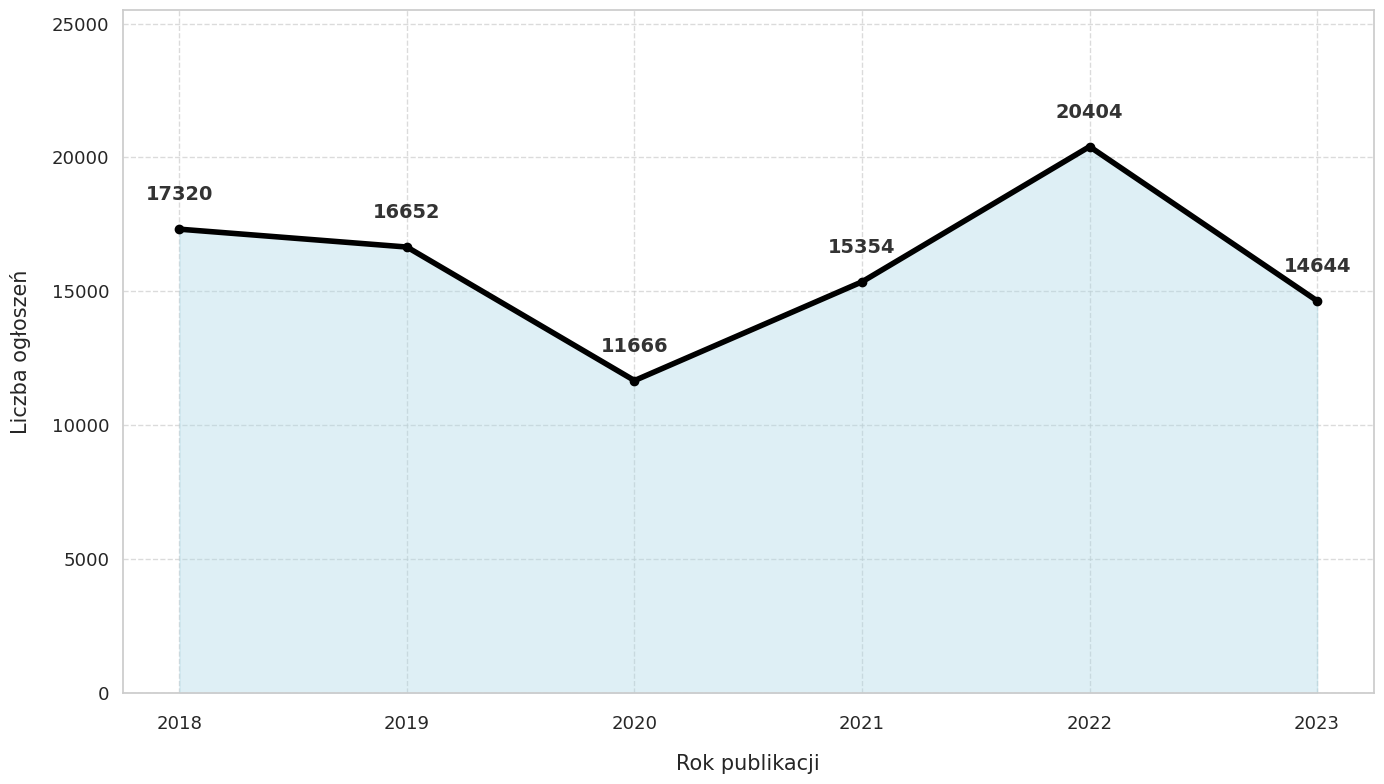

In [95]:
# Number of ads in time.
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.titlesize': 18,
    'axes.labelsize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
})

plt.figure(figsize=(14, 8))

# Calculate counts per year and sort by year for time series
counts = df['year'].value_counts().sort_index()

# Plotting the line with increased linewidth
ax = counts.plot(kind='line', marker='o', color='#000000', linewidth=4, zorder=3)

# Adding the shaded area below the line
plt.fill_between(counts.index, counts.values, color='#ADD8E6', alpha=0.4)

plt.xlabel('Rok publikacji', labelpad=15)
plt.ylabel('Liczba ogłoszeń', labelpad=15)

ax.tick_params(axis='x', pad=10)

# Annotate each point with its value with increased fontsize
for x, y in zip(counts.index, counts.values):
    ax.annotate(
        f'{int(y)}',
        (x, y),
        textcoords="offset points",
        xytext=(0, 18), # Increased offset slightly
        ha='center',
        va='bottom',
        fontsize=14, # Increased fontsize to 14
        fontweight='bold',
        color='#333333'
    )

ax.set_ylim(0, counts.max() * 1.25) # Adjusted y-limit further for larger annotations
plt.grid(True, linestyle='--', alpha=0.7, zorder=0)
plt.tight_layout()

# export
plt.savefig("year_var.png", format="png", bbox_inches="tight")
plt.show()

##### Correlation

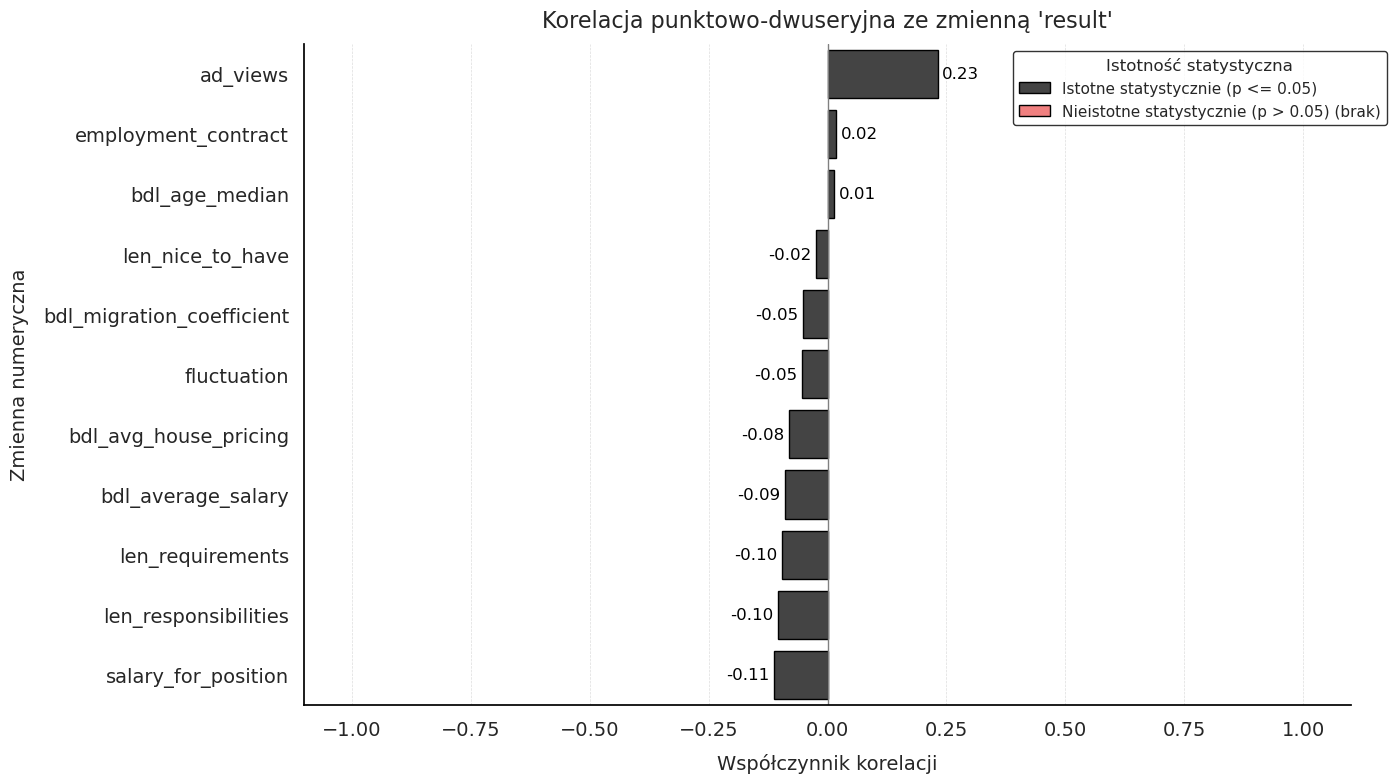


Szczegółowe wyniki korelacji:
                           correlation  is_statistically_significant
ad_views                      0.231427                             1
employment_contract           0.017761                             1
bdl_age_median                0.013534                             1
len_nice_to_have             -0.023733                             1
bdl_migration_coefficient    -0.050769                             1
fluctuation                  -0.053511                             1
bdl_avg_house_pricing        -0.081331                             1
bdl_average_salary           -0.088522                             1
len_requirements             -0.096059                             1
len_responsibilities         -0.104691                             1
salary_for_position          -0.113068                             1


In [96]:
from scipy import stats

numerical_columns = [
    'ad_views',
    'salary_for_position',
    'fluctuation',
    'employment_contract',
    'bdl_avg_house_pricing',
    'bdl_age_median',
    'bdl_migration_coefficient',
    'bdl_average_salary',
    'len_requirements',
    'len_nice_to_have',
    'len_responsibilities'
]

correlation_results = {}
for col in numerical_columns:
    x = df['result']
    y = df[col]
    valid = x.notna() & y.notna()
    if sum(valid) > 1:
        r, p = stats.pointbiserialr(x[valid], y[valid])
        correlation_results[col] = {
            'correlation': r,
            'is_statistically_significant': int(p <= 0.05)
        }
    else:
        print(f"Brak wystarczających danych do obliczenia korelacji dla kolumny: {col}")

correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index')
correlation_df = correlation_df.sort_values(by=['is_statistically_significant', 'correlation'], ascending=[False, False])

sns.set(style='whitegrid')
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'grid.color': '#DDDDDD',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'axes.edgecolor': 'black'
})

plt.figure(figsize=(14, max(8, len(numerical_columns) * 0.6)))

bar_color_significant = '#444444' # Ciemny szary

ax = sns.barplot(
    x='correlation',
    y=correlation_df.index,
    data=correlation_df,
    color=bar_color_significant,
    edgecolor='black',
    ax=plt.gca()
)

ax.set_ylabel("Zmienna numeryczna", labelpad=10)
ax.set_xlabel("Współczynnik korelacji", labelpad=10)
ax.tick_params(axis='y', pad=5)
ax.tick_params(axis='x', pad=5)

for p in ax.patches:
    width = p.get_width()
    if width >= 0:
        ax.annotate(f'{width:.2f}',
                    (width + 0.01, p.get_y() + p.get_height() / 2.),
                    ha='left', va='center', fontsize=12, color='black')
    else:
        ax.annotate(f'{width:.2f}',
                    (width - 0.01, p.get_y() + p.get_height() / 2.),
                    ha='right', va='center', fontsize=12, color='black')

ax.set_xlim(-1.1, 1.1)
ax.axvline(0, color='gray', linestyle='-', linewidth=1)
ax.set_title("Korelacja punktowo-dwuseryjna ze zmienną 'result'", pad=12)
sns.despine(left=False, bottom=False)

from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=bar_color_significant, edgecolor='black', label='Istotne statystycznie (p <= 0.05)'),
    Patch(facecolor='lightcoral', edgecolor='black', label='Nieistotne statystycznie (p > 0.05) (brak)')
]

ax.legend(handles=legend_elements,
          title='Istotność statystyczna',
          frameon=True,
          edgecolor='black',
          bbox_to_anchor=(0.67, 1),
          loc='upper left')

plt.tight_layout()

plt.savefig(f"point_biserial_correlation.png", format="png", bbox_inches="tight")
plt.show()

print("\nSzczegółowe wyniki korelacji:")
print(correlation_df)

In [97]:
df[numerical_columns].describe()

,ad_views,salary_for_position,fluctuation,employment_contract,bdl_avg_house_pricing,bdl_age_median,bdl_migration_coefficient,bdl_average_salary,len_requirements,len_nice_to_have,len_responsibilities
count,96040.000000,96040.000000,96040.000000,96040.000000,96040.000000,96040.000000,96040.000000,96040.000000,96040.000000,96040.000000,96040.000000
mean,2067.338047,6041.427301,0.099069,577.759261,7123.717628,41.950353,2811.867024,6412.095721,7.732663,3.258871,5.366524
std,843.645392,1650.320724,0.087798,657.441935,2939.196058,1.780767,4011.859714,1509.840859,3.085298,2.496036,2.230622
min,124.000000,990.833333,0.000000,0.050000,0.000000,34.600000,-1065.000000,3183.340000,2.000000,0.000000,0.000000
25%,1337.000000,4840.697276,0.066502,18.300000,4743.000000,40.700000,-171.000000,5252.170000,6.000000,1.000000,4.000000
50%,2146.000000,5833.339921,0.081996,284.850000,6656.000000,41.500000,189.000000,6432.780000,7.000000,3.000000,5.000000
75%,2622.000000,6831.692744,0.110191,820.250000,9129.000000,43.300000,6224.000000,7391.950000,9.000000,5.000000,7.000000
max,11725.000000,22911.326995,3.846154,3271.880000,15717.000000,48.900000,11727.000000,12804.030000,31.000000,23.000000,32.000000


##### Bar charts

In [98]:
def plot_ibcs_bar_chart(df: pd.DataFrame, group_col: str, old_to_new_labels: dict = None, category_order: list = None):
    group_means = df.groupby(group_col)['result'].mean().reset_index()
    group_means[group_col] = group_means[group_col].astype(str)

    if old_to_new_labels:
        group_means[group_col] = group_means[group_col].apply(
            lambda x: old_to_new_labels.get(x, x)
        )

    if category_order:
        group_means[group_col] = pd.Categorical(group_means[group_col], categories=category_order, ordered=True)
    else:
        # Default: sort descending by mean
        group_means.sort_values(by='result', ascending=False, inplace=True)

    n_categories = group_means.shape[0]
    ibcs_palette = '#5A5A5A'
    colors = [ibcs_palette] * n_categories

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        y=group_col,
        x='result',
        data=group_means,
        palette=colors[:n_categories],
        edgecolor='black'
    )

    ax.set_ylabel(group_col, labelpad=10)
    ax.set_xlabel("Średni odsetek udanych obsadzeń", labelpad=10)
    ax.tick_params(axis='y', pad=5)

    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{width:.2f}',
                    (width + 0.01, p.get_y() + p.get_height() / 2.),
                    ha='left', va='center', fontsize=14)

    ax.set_xlim(0, group_means['result'].max() * 1.10)

    sns.set(style='whitegrid')
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
    })
    sns.despine()
    plt.tight_layout()

    # Export
    plt.savefig(f"mean_result_by_{group_col}.png", format="png", bbox_inches="tight")
    plt.show()

C:\Users\Konrad\AppData\Local\Temp\ipykernel_16560\17813786.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


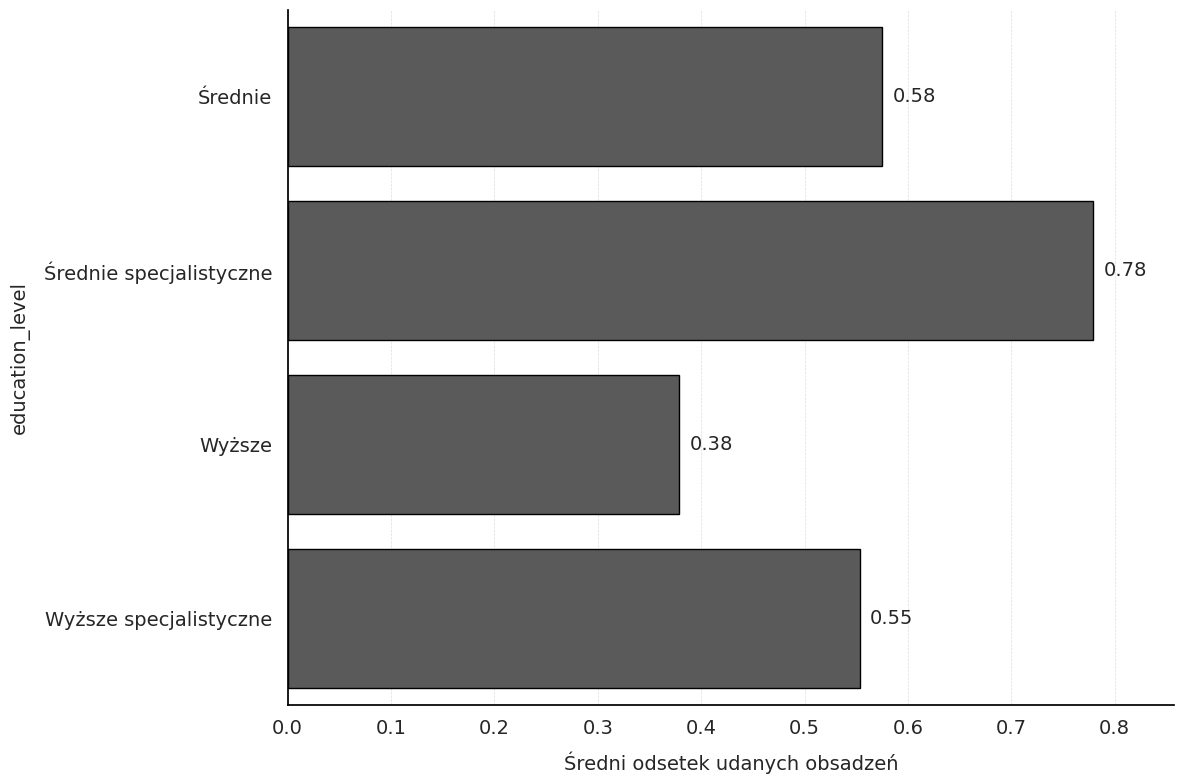

C:\Users\Konrad\AppData\Local\Temp\ipykernel_16560\17813786.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


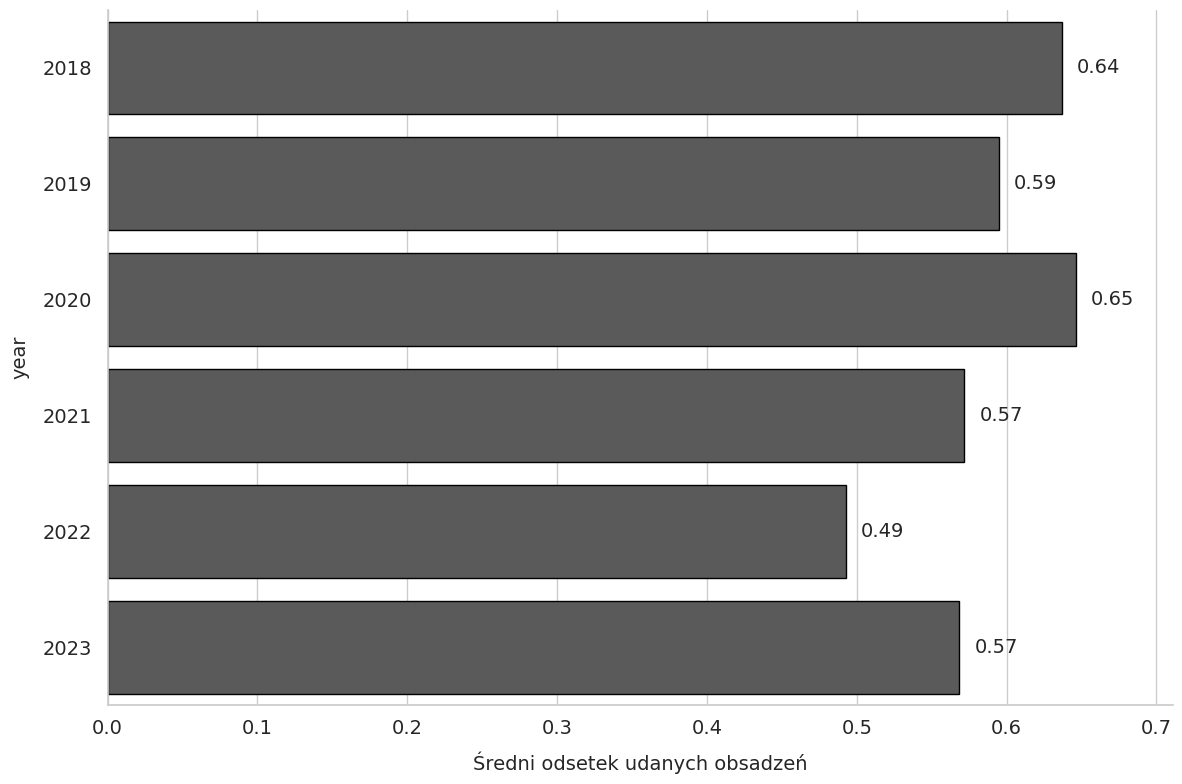

C:\Users\Konrad\AppData\Local\Temp\ipykernel_16560\17813786.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


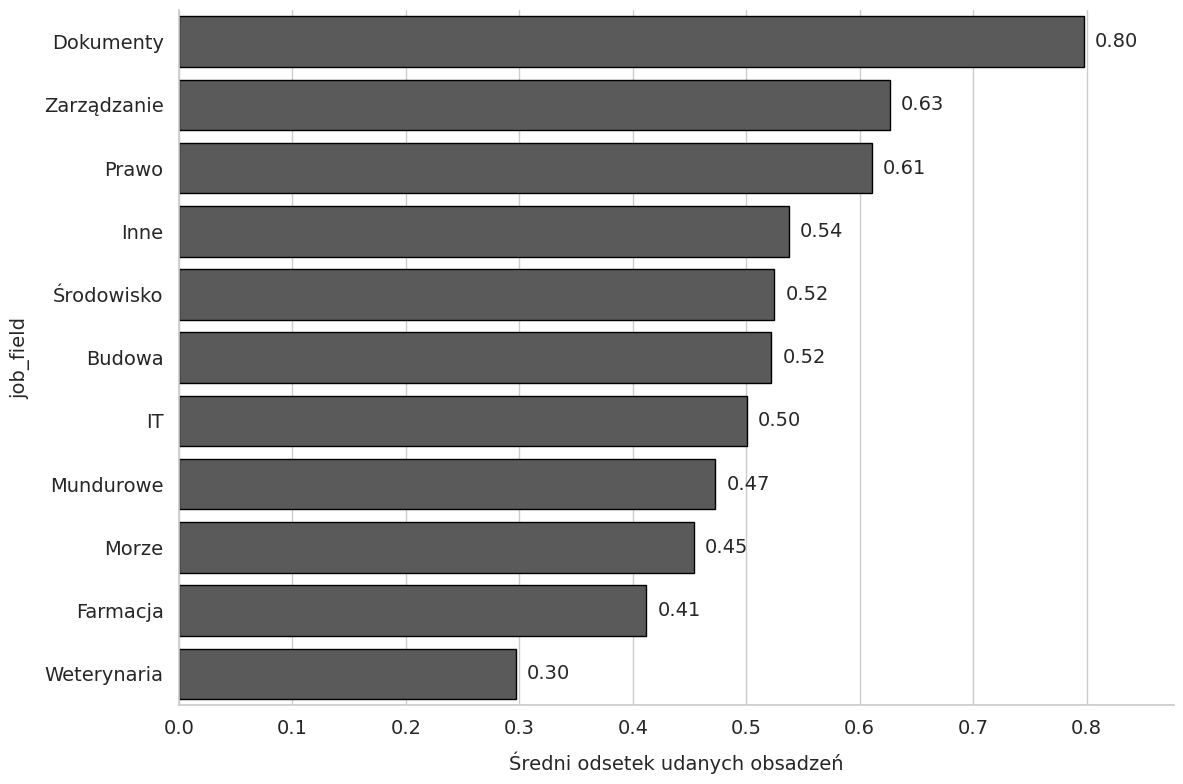

C:\Users\Konrad\AppData\Local\Temp\ipykernel_16560\17813786.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


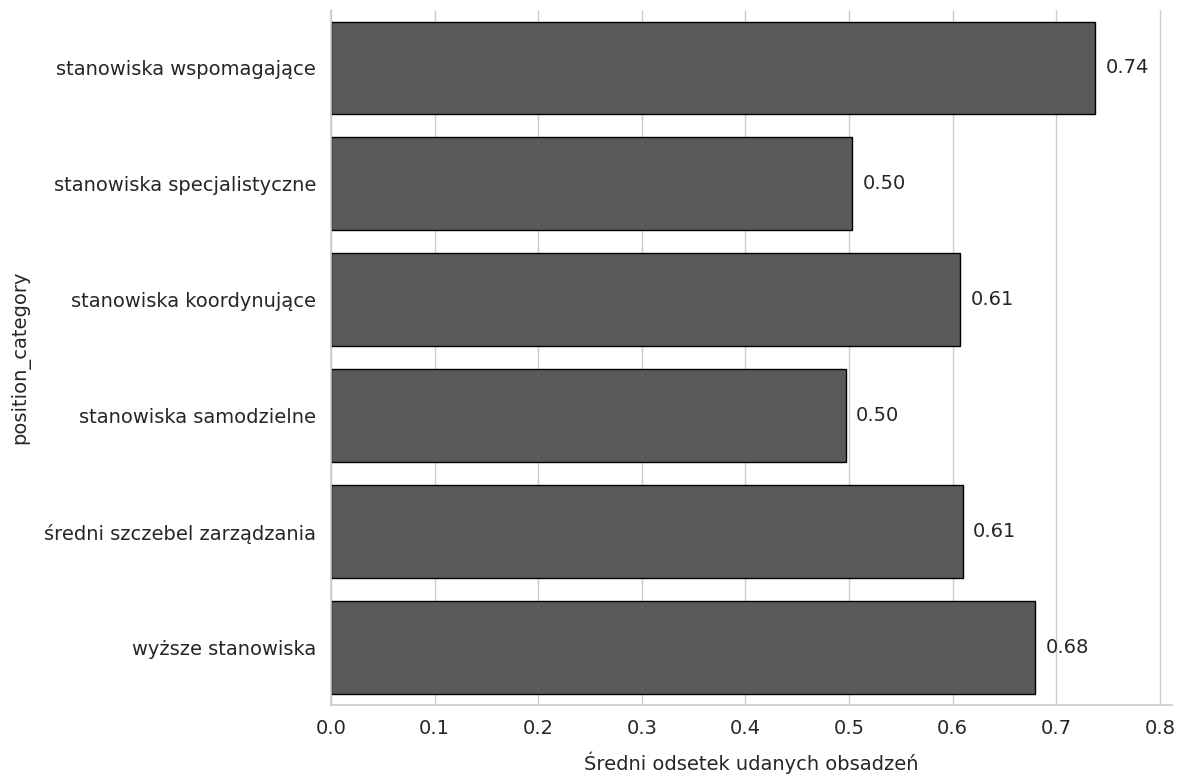

In [99]:
education_level_dict = {
    '1': "Średnie",
    '2': "Średnie specjalistyczne",
    '3': "Wyższe",
    '4': "Wyższe specjalistyczne"
}

job_field_dict = {
    'law': 'Prawo',
    'documents': 'Dokumenty',
    'vet': 'Weterynaria',
    'other': 'Inne',
    'uniformed services': 'Mundurowe',
    'IT/statistics': 'IT',
    'tech/construction': 'Budowa',
    'environment': 'Środowisko',
    'pharmacy/chemistry': 'Farmacja',
    'other_manager': 'Zarządzanie',
    'water': 'Morze'
}

education_level_order = ["Średnie", "Średnie specjalistyczne", "Wyższe", "Wyższe specjalistyczne"]
year_order = ['2018', '2019', '2020', '2021', '2022', '2023']
position_category_order = ["stanowiska wspomagające", "stanowiska specjalistyczne", "stanowiska koordynujące", "stanowiska samodzielne", "średni szczebel zarządzania", "wyższe stanowiska"]

plot_ibcs_bar_chart(df, 'education_level', education_level_dict, education_level_order)
plot_ibcs_bar_chart(df, 'year', category_order=year_order)
plot_ibcs_bar_chart(df, 'job_field', job_field_dict)
plot_ibcs_bar_chart(df, 'position_category', category_order=position_category_order)

##### Time series

In [100]:
# Dropping cols unnecessary for statistical analyses.
string_cols_for_temporary_dropping = [
    'ad_id',
    'institution_address',
    'workplace',
    'department',
    'date_announced',
    'institution_address',
    'workplace',
    'department',
    'city',
    'position',
    'vacancies'
]

df_for_charts = df.drop(string_cols_for_temporary_dropping, axis=1)
df_for_charts["voivodeship_district"] = df_for_charts['voivodeship'].astype(str) + df_for_charts['district'].astype(str)

In [101]:
# Time series for the chosen set of variables.
df_for_charts_time_series = df_for_charts[['ad_views', 'result', 'offer_salary_mentioned', 'fluctuation', 'year']]
# Unifying scale.
import numpy as np
df_for_charts_time_series['ad_views_/_10000'] = df_for_charts_time_series['ad_views'] / 10000
df_for_charts_time_series.drop(['ad_views'], axis=1, inplace=True)

C:\Users\Konrad\AppData\Local\Temp\ipykernel_16560\373324191.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_charts_time_series['ad_views_/_10000'] = df_for_charts_time_series['ad_views'] / 10000
C:\Users\Konrad\AppData\Local\Temp\ipykernel_16560\373324191.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_charts_time_series.drop(['ad_views'], axis=1, inplace=True)


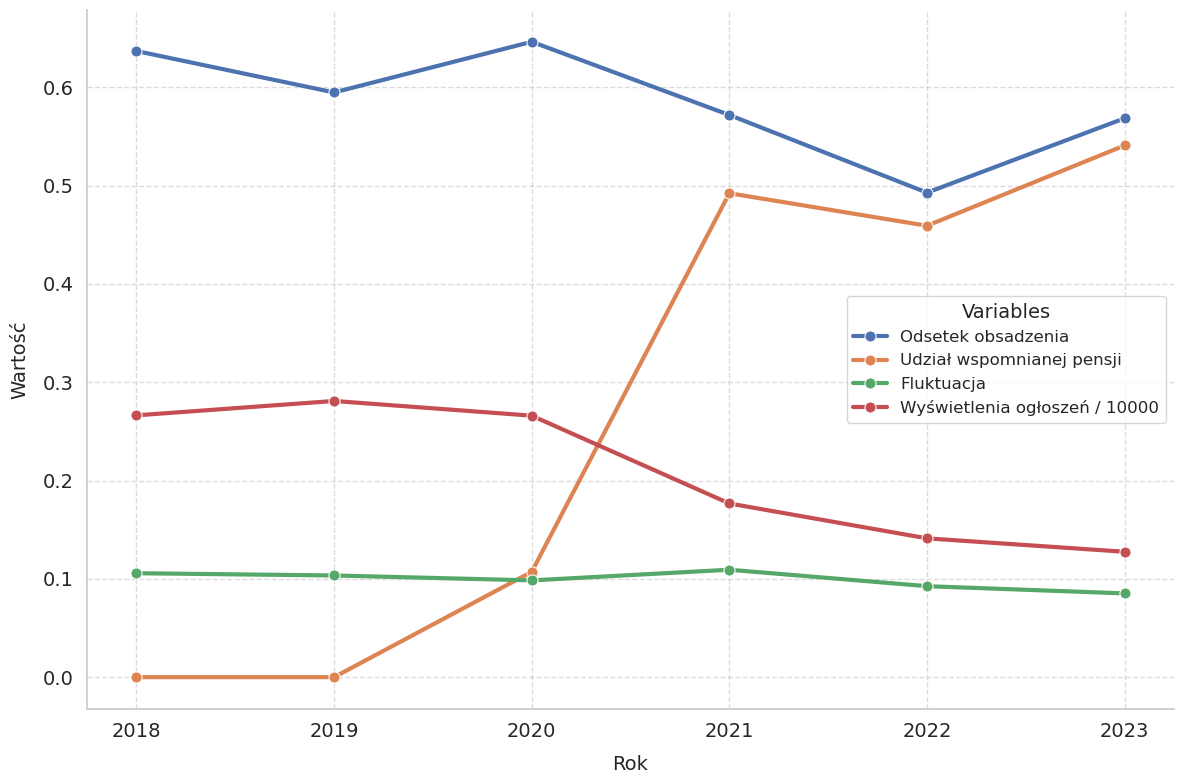

In [102]:
def plot_individual_time_series_combined(dataframe):
    df_grouped = dataframe.groupby('year').mean(numeric_only=True)
    columns_to_plot = [col for col in df_grouped.columns]

    custom_labels = {
        'result': 'Odsetek obsadzenia',
        'offer_salary_mentioned': 'Udział wspomnianej pensji',
        'fluctuation': 'Fluktuacja',
        'ad_views_/_10000': 'Wyświetlenia ogłoszeń / 10000'
    }

    sns.set(style='whitegrid')
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
    })

    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    for column in columns_to_plot:
        label_to_use = custom_labels.get(column, column.replace('_', ' ').title())

        sns.lineplot(
            x=df_grouped.index,
            y=df_grouped[column],
            marker='o',
            markersize=8,
            linewidth=3,
            label=label_to_use,
            ax=ax
        )

    ax.set_xlabel("Rok", labelpad=10)
    ax.set_ylabel("Wartość", labelpad=10)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(True, linestyle='--', linewidth=1, alpha=0.7)
    ax.legend(title='Variables', fontsize=12, title_fontsize=14, loc='best')

    sns.despine()
    plt.tight_layout()
    plt.savefig("combined_time_series.png", format="png", bbox_inches="tight")
    plt.show()

plot_individual_time_series_combined(df_for_charts_time_series)

##### Variability charts

In [103]:
# def plot_variability(dataframe):
#     exclude_columns = ['work_time', 'year', 'district', 'voivodeship', 'institution']
#     df_grouped = dataframe.groupby('district').mean(numeric_only=True)
#     columns_to_plot = [col for col in df_grouped.columns if col not in exclude_columns]
# 
#     sns.set(style="whitegrid", context="talk", palette="deep")
# 
#     for column in columns_to_plot:
#         plt.figure(figsize=(12, 6))
#         sns.lineplot(x=df_grouped.index, y=df_grouped[column], marker='o', linewidth=2.5)
#         plt.title(f"{column.replace('_', ' ').title()} District Variability", fontsize=16, weight='bold')
#         plt.xlabel("District", fontsize=13)
#         plt.ylabel(column.replace('_', ' ').title(), fontsize=13)
#         plt.xticks(rotation=45, fontsize=11)
#         plt.yticks(fontsize=11)
#         plt.grid(visible=True, linestyle='--', alpha=0.7)
#         plt.tight_layout()
#         plt.show()
# 
# plot_variability(df_for_charts)

##### Spaghetti plots

In [70]:
df_for_charts_district_agg = df_for_charts.groupby(by=['voivodeship_district', 'year'])['result'].mean()
df_for_charts_institution_agg = df_for_charts.groupby(by=['institution', 'year'])['result'].mean()

In [71]:
def plot_spaghetti_chart(df_grouped, group_cols, file_title):
    df = df_grouped.reset_index()
    
    groups = df.groupby(group_cols)

    plt.figure(figsize=(10, 6))
    for group_vals, group_data in groups:
        label = '-'.join(map(str, group_vals)) if isinstance(group_vals, tuple) else str(group_vals)
        plt.plot(group_data['year'], group_data['result'], label=label)

    plt.xlabel('Year')
    plt.ylabel('Result')
    plt.tight_layout()
    plt.savefig(file_title, format="png", bbox_inches="tight")
    plt.show()

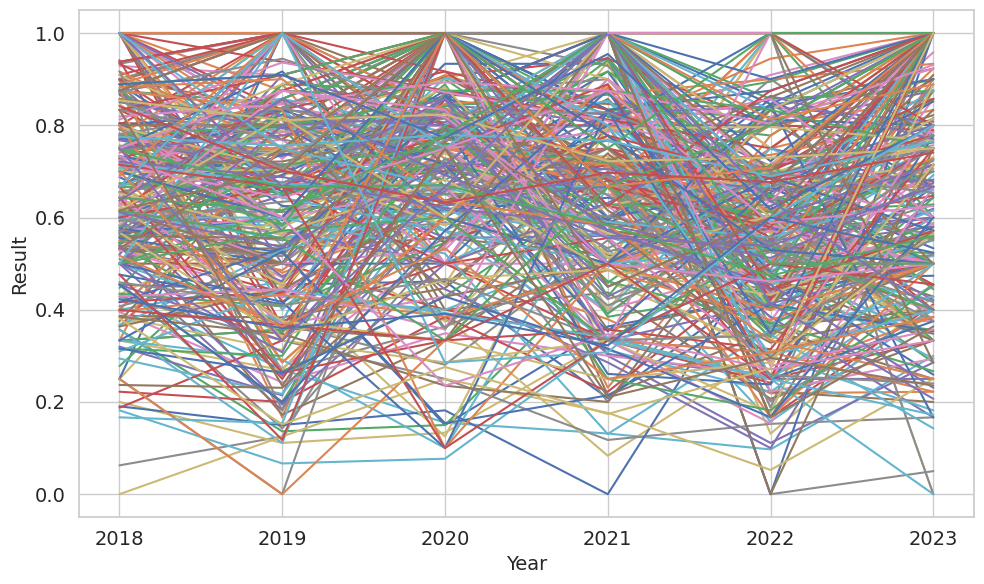

In [72]:
plot_spaghetti_chart(df_for_charts_district_agg, ['voivodeship_district'], "spaghetti_district.png")

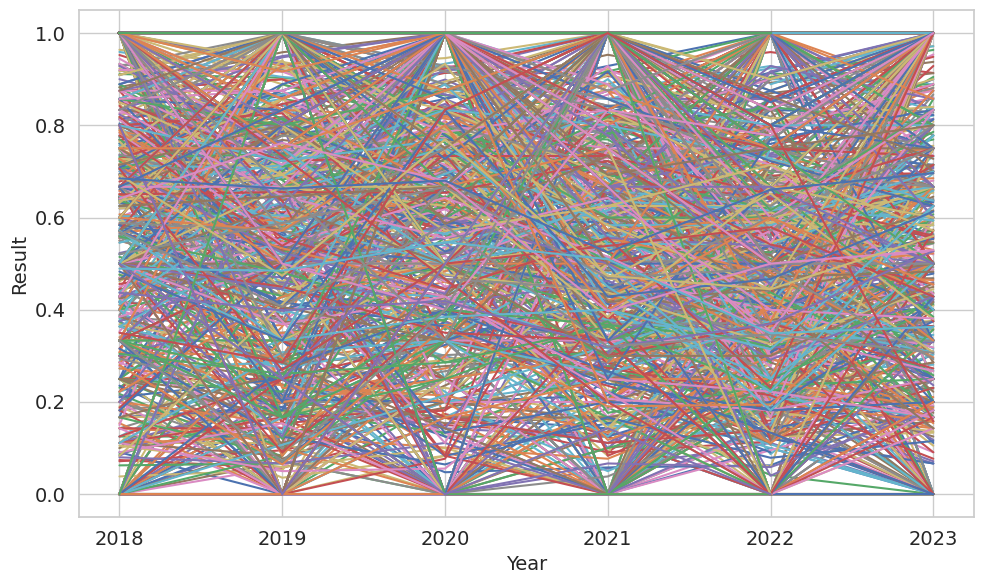

In [73]:
plot_spaghetti_chart(df_for_charts_institution_agg, ['institution'], "spaghetti_institution.png")

## Feature importance

In [104]:
# bdl_avg_salary, salary_for_position, and bdl_housing are correlated with each other.
df['relative_salary'] = df['salary_for_position'] / df['bdl_average_salary']
df.drop(['salary_for_position', 'bdl_average_salary', 'bdl_avg_house_pricing'], axis=1, inplace=True)

##### Preparing data for logistic regression

In [105]:
# Dealing with categorical columns with the use of USM method
# (an alternative to 1hot encoding in which each category is represented by coefficients that sum to zero).

education_matrix = dmatrix('C(education_level, Sum)', df, return_type='dataframe').iloc[:, 1:]
df = pd.concat([df.drop('education_level', axis=1), education_matrix], axis=1)

position_matrix = dmatrix('C(position_category, Sum)', df, return_type='dataframe').iloc[:, 1:]
job_field_matrix = dmatrix('C(job_field, Sum)', df, return_type='dataframe').iloc[:, 1:]

df = pd.concat([df.drop(['position_category', 'job_field'], axis=1), position_matrix, job_field_matrix], axis=1)

In [106]:
# I am removing city since it is going to be used later on.
string_cols_for_temporary_dropping.remove('city'),
df_model = df.drop(string_cols_for_temporary_dropping, axis=1)
df_model['voivodeship_district'] = df_model['voivodeship'].astype(str) + df_model['district'].astype(str)
df_model.drop(['voivodeship', 'district'], axis=1, inplace=True)

In [107]:
# Excluding institutions that posted less than 10 job ads

# Calculate the frequency of each institution.
institution_counts = df_model['institution'].value_counts()

# Identify institutions to exclude.
institutions_to_exclude = institution_counts[institution_counts < 10].index

# Filter df_model to keep only institutions that appear 10 or more times.
df_model = df_model[~df_model['institution'].isin(institutions_to_exclude)]

In [108]:
# Excluding institutions that are 0- or 1-inflated.
institutions_inflated = []
for institution, group in df_model.groupby('institution'):
    unique_results = group['result'].unique()
    if len(unique_results) == 1 and (unique_results[0] == 0 or unique_results[0] == 1):
        institutions_inflated.append(institution)

df_model = df_model[~df_model['institution'].isin(institutions_inflated)]

In [109]:
# Making year a categorical col
df_model['year_after_2020'] = (df_model['year'] >= 2020).astype(int)
df_model['year_before_2020'] = (df_model['year'] < 2020).astype(int)
df_model.drop(['year'], axis=1, inplace=True)

In [110]:
# # Log transformations before performing standardization.
# variables_to_plot = ['ad_views', 'relative_salary', 'fluctuation', 'employment_contract', 'foreign_capital', 'unemployment', 'bdl_age_median', 'bdl_migration_coefficient']
# 
# for column in variables_to_plot:
#     plt.figure(figsize=(10, 6))
#     sns.histplot(df_model[column], kde=True)
#     plt.title(f'Distribution of {column}')
#     plt.xlabel(column)
#     plt.ylabel('Frequency')
#     plt.tight_layout()
#     plt.show()

In [111]:
variables_to_log_transform = ['ad_views', 'relative_salary', 'foreign_capital', 'fluctuation', 'employment_contract']
for col in variables_to_log_transform:
    df_model[col] = np.log1p(df_model[col])

In [112]:
# I'm using cuberoot transformation for the migration coefficient, since it contains negative values.
df_model['bdl_migration_coefficient'] = np.cbrt(df_model['bdl_migration_coefficient'])

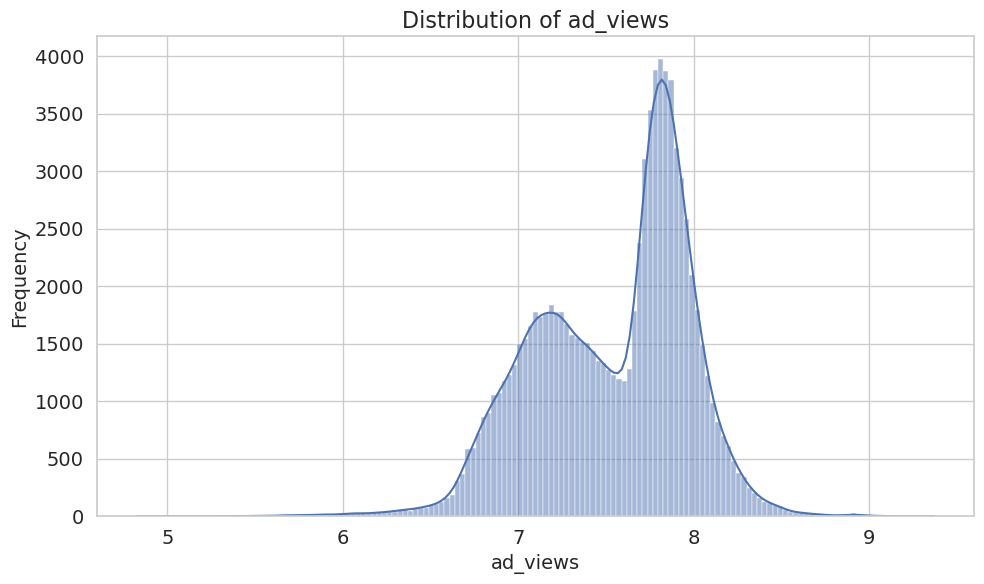

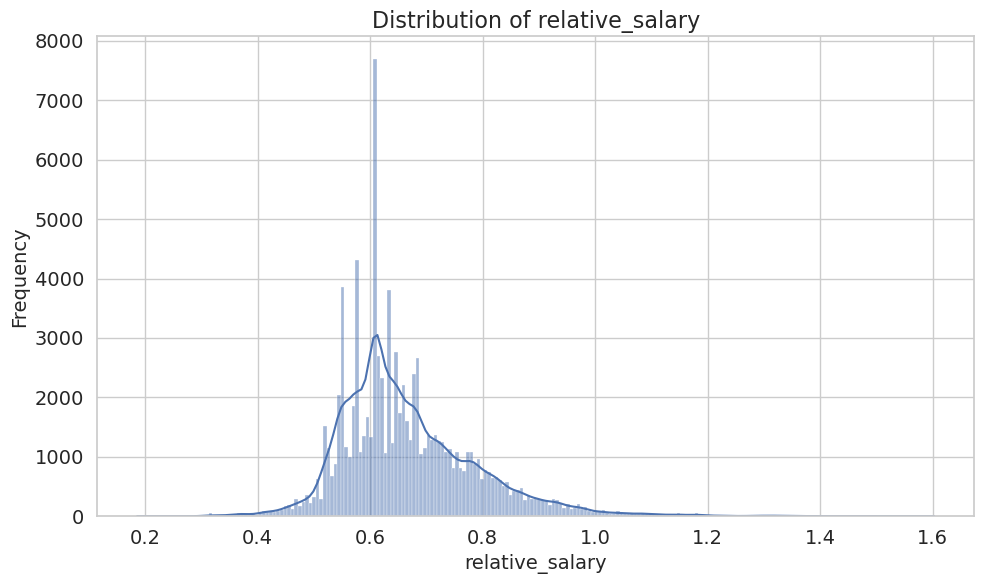

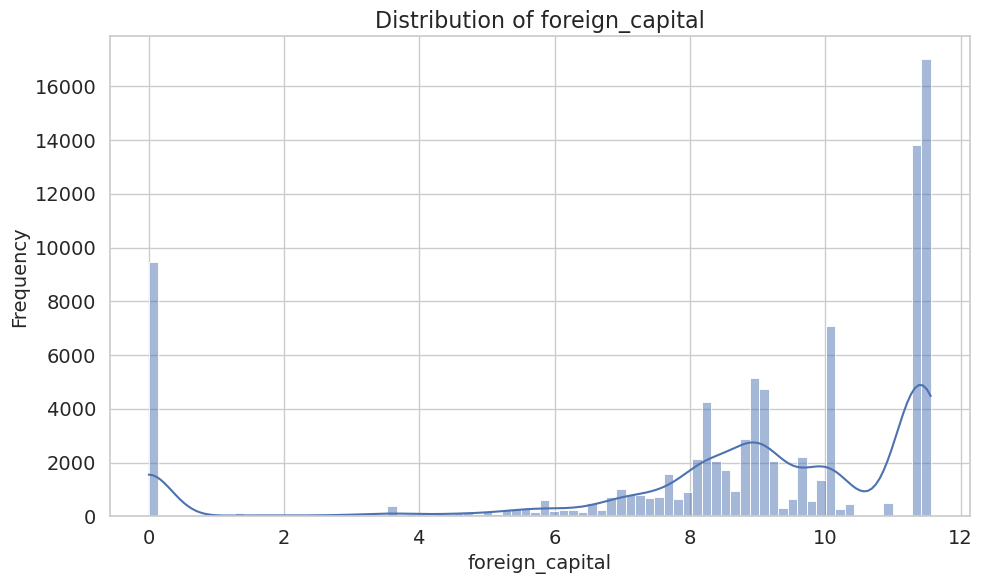

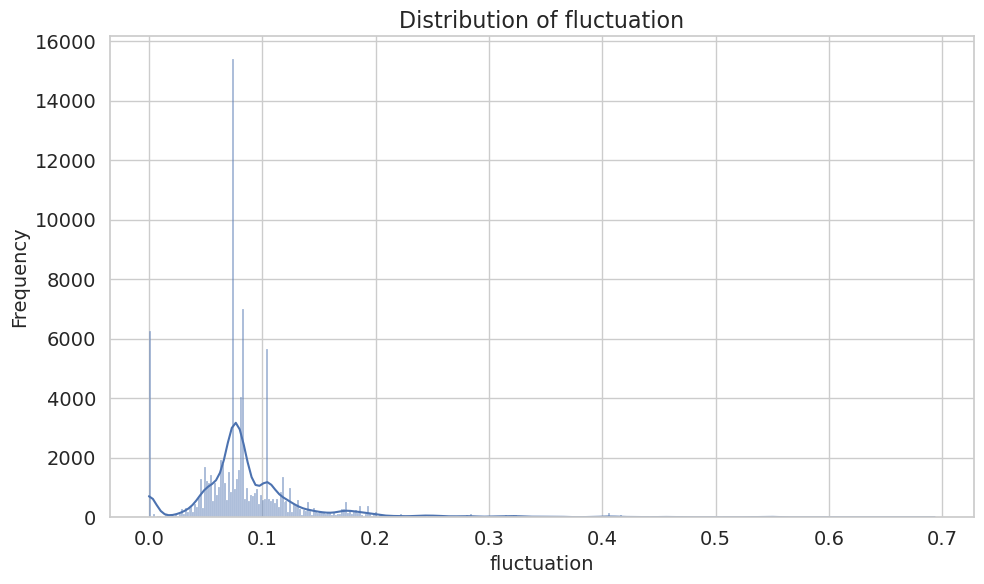

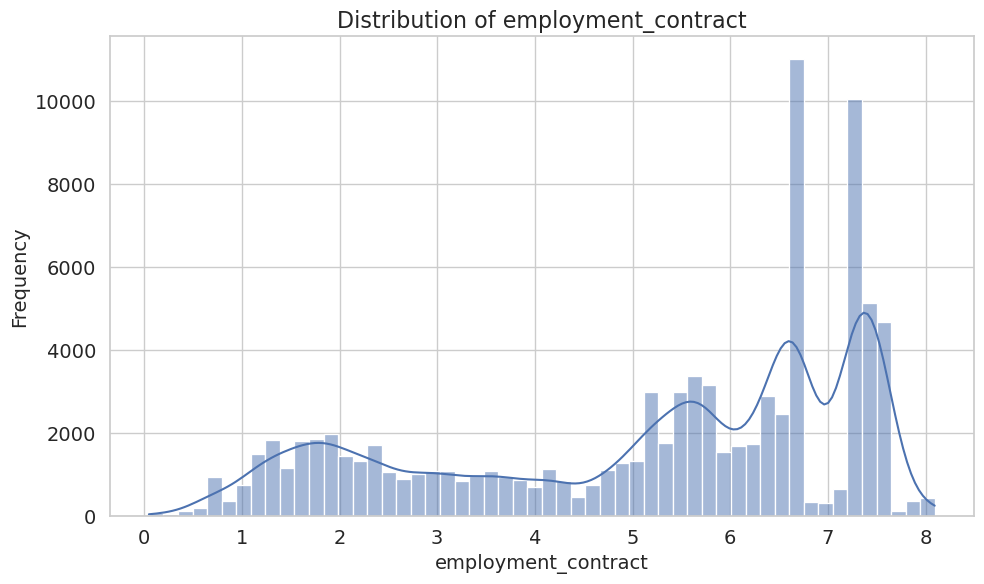

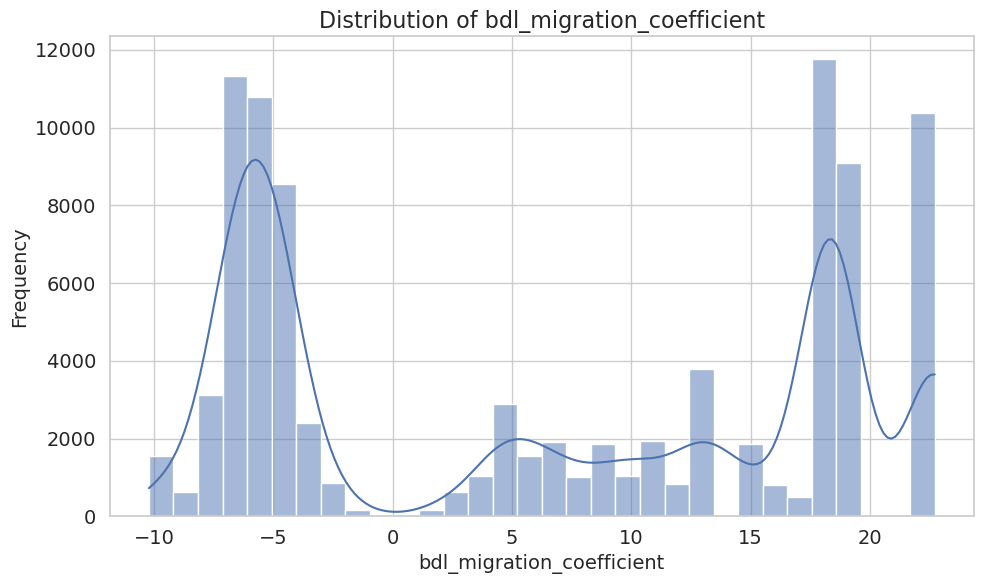

In [113]:
# Plotting distributions after transformation.
transformed_variables_to_plot = ['ad_views', 'relative_salary', 'foreign_capital', 'fluctuation', 'employment_contract', 'bdl_migration_coefficient']

for column in transformed_variables_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_model[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [114]:
from sklearn.model_selection import train_test_split

# Stratified train-test split (90% train, 10% test) based on an institution.
df_train1, df_test1 = train_test_split(
    df_model,
    test_size=0.1,
    stratify=df_model['institution'],
    random_state=42
)

# Repeating the steps that had been applied for institutions for districts.
# Remark: this step is not described in the thesis, since we only need this to ensure districts are evenly distributed in an alternative dataset, divided by districts and without institutions, for a later DALEX chart.

# MEANING OF PARTICULAR DATASETS NAMES
# df...1 --> stratified sampling with the use of institution.
# df...2 --> stratified sampling with the use of district.

df_model2 = df_model.copy()
districts_counts = df_model2['voivodeship_district'].value_counts()
districts_to_exclude = districts_counts[districts_counts < 10].index
df_model2 = df_model2[~df_model2['voivodeship_district'].isin(institutions_to_exclude)]
districts_inflated = []
for district, group in df_model.groupby('voivodeship_district'):
    unique_results = group['result'].unique()
    if len(unique_results) == 1 and (unique_results[0] == 0 or unique_results[0] == 1):
        districts_inflated.append(district)

df_model2 = df_model2[~df_model2['voivodeship_district'].isin(districts_inflated)]

# Stratified train-test split (90% train, 10% test) based on a district.
df_train2, df_test2 = train_test_split(
    df_model2,
    test_size=0.1,
    stratify=df_model2['voivodeship_district'],
    random_state=42
)

In [117]:
# MEANING OF PARTICULAR DATASET NAMES
# df...1 --> stratified sampling with the use of institution.
# df...2 --> stratified sampling with the use of district.

# df{number} --> model without districts and institutions, grouped at ad level, using {number} stratified sampling.
# df_institution{number}--> model without districts, grouped at institution level, using {number} stratified sampling.
# df_district{number}--> model without institutions, grouped at district level, using {number} stratified sampling.

# df1_poznan includes only institutions located in the city of Poznań or its surroundings.

def standardize_and_encode(df_train, df_test):
    """
    Standardize features and create categorical encodings for train/test splits.

    Args:
        df_train: Training dataframe
        df_test: Test dataframe

    Returns:
        tuple: (df_train_scaled, df_test_scaled, df_train_institutions, df_test_institutions,
                df_train_districts, df_test_districts)
    """
    from sklearn.preprocessing import StandardScaler

    # Excluding categorical cols.
    position_category_cols = df_train.filter(regex=r'^position_category').columns.tolist()
    job_field_cols = df_train.filter(regex=r'^job_field').columns.tolist()
    cols_to_exclude_from_standarization = ['result', 'institution', 'voivodeship_district', 'year_after_2020', 'year_before_2020', 'city'] + position_category_cols + job_field_cols

    # Standardization
    scaler = StandardScaler()
    X_train_features = df_train.drop(cols_to_exclude_from_standarization, axis=1)
    scaler.fit(X_train_features)
    X_train_scaled = scaler.transform(X_train_features)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_features.columns, index=X_train_features.index)
    X_train_scaled_df = pd.concat([X_train_scaled_df, df_train[cols_to_exclude_from_standarization]], axis=1)

    # Standardizing the test set (with the scaler fitted on the training data).
    X_test_features = df_test.drop(cols_to_exclude_from_standarization, axis=1)
    X_test_scaled = scaler.transform(X_test_features)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_features.columns, index=X_test_features.index)
    X_test_scaled_df = pd.concat([X_test_scaled_df, df_test[cols_to_exclude_from_standarization]], axis=1)

    # Create categorical encodings
    institution_matrix_train = dmatrix('C(institution, Sum)', X_train_scaled_df, return_type='dataframe').iloc[:, 1:]
    district_matrix_train = dmatrix('C(voivodeship_district, Sum)', X_train_scaled_df, return_type='dataframe').iloc[:, 1:]

    df_train_institutions = pd.concat([X_train_scaled_df.drop(['institution', 'voivodeship_district', 'city'], axis=1), institution_matrix_train], axis=1)
    df_train_districts = pd.concat([X_train_scaled_df.drop(['institution', 'voivodeship_district', 'city'], axis=1), district_matrix_train], axis=1)

    institution_matrix_test = dmatrix('C(institution, Sum)', X_test_scaled_df, return_type='dataframe').iloc[:, 1:]
    district_matrix_test = dmatrix('C(voivodeship_district, Sum)', X_test_scaled_df, return_type='dataframe').iloc[:, 1:]

    df_test_institutions = pd.concat([X_test_scaled_df.drop(['institution', 'voivodeship_district', 'city'], axis=1), institution_matrix_test], axis=1)
    df_test_districts = pd.concat([X_test_scaled_df.drop(['institution', 'voivodeship_district', 'city'], axis=1), district_matrix_test], axis=1)

    # Create a df for institutions only from Poznań.
    df_poznan_train = X_train_scaled_df[X_train_scaled_df['city'].str.contains(r'poznań', regex=True, case=False, na=False)]
    df_poznan_train = df_poznan_train.drop(['institution', 'voivodeship_district', 'city'], axis=1)
    df_poznan_test = X_test_scaled_df[X_test_scaled_df['city'].str.contains(r'poznań', regex=True, case=False, na=False)]
    df_poznan_test = df_poznan_test.drop(['institution', 'voivodeship_district', 'city'], axis=1)

    # Clean main dataframes
    df_train_scaled = X_train_scaled_df.drop(['institution', 'voivodeship_district', 'city'], axis=1)
    df_test_scaled = X_test_scaled_df.drop(['institution', 'voivodeship_district', 'city'], axis=1)

    return df_train_scaled, df_test_scaled, df_train_institutions, df_test_institutions, df_train_districts, df_test_districts, df_poznan_train, df_poznan_test

# Apply to both splits
df_train1, df_test1, df_train1_institutions, df_test1_institutions, df_train1_districts, df_test1_districts, df_poznan1_train, df_poznan1_test = standardize_and_encode(df_train1, df_test1)
df_train2, df_test2, df_train2_institutions, df_test2_institutions, df_train2_districts, df_test2_districts, df_poznan2_train, df_poznan2_test = standardize_and_encode(df_train2, df_test2)

##### Applying logistic regression

In [118]:
# Function grouping together 1hot encoded categorical variables for dalex's Explainer.
def create_variable_groups(encoded_df, original_categorical_cols):
    dalex_variable_groups = {}

    for cat_col in original_categorical_cols:
        # Find all dummy columns for this categorical variable
        dummy_cols = [col for col in encoded_df.columns
                     if col.startswith(f'C({cat_col}, Sum)[S.')]

        if dummy_cols:
            dalex_variable_groups[cat_col] = dummy_cols

    return dalex_variable_groups

In [119]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import dalex as dx
import warnings
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio # Import plotly.io for image export

def log_regression(train_set, test_set, penalty, solver, cv, original_categorical_cols:list):
    def one_minus_auc(y_true, y_pred):
        # For binary classification, y_pred should typically be probabilities of the positive class
        # If y_pred from your model is already probabilities, you can use it directly
        # Otherwise, you might need to extract the positive class probabilities: y_pred[:, 1]
        return 1 - roc_auc_score(y_true, y_pred)

    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    np.random.seed(42)

    X_train = train_set.drop('result', axis=1)
    y_train = train_set['result']
    X_test = test_set.drop('result', axis=1)
    y_test = test_set['result']

    model = LogisticRegression(penalty=penalty, solver=solver, random_state=42, max_iter=5000)

    param_grid = {
        'C': np.logspace(-4, 2, 7)
    }

    print("\nGridSearchCV")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    optimal_C = grid_search.best_params_['C']
    best_logistic_model = grid_search.best_estimator_

    print(f"\nOptimal C found: {optimal_C}")
    print(f"Best cross-validation ROC AUC: {grid_search.best_score_:.4f}")

    print("\nInitializing DALEX Explainer")

    explainer = dx.Explainer(
        model = best_logistic_model,
        data = X_train,
        y = y_train,
        verbose=False,
        label=f"Logistic Regression (Optimal C={optimal_C:.4f}, Penalty={penalty})"
    )

    print("Calculating DALEX Feature Importance (Combined)")

    # 1. Get feature importance for all individual features
    fi_all_features_result = explainer.model_parts(B=20, type='ratio', loss_function=one_minus_auc).result.copy()

    # Filter out the 'baseline' row from the individual features result (I only want to plot actual features).
    fi_all_features_result = fi_all_features_result[fi_all_features_result['variable'] != '_baseline_'].copy()

    # 2. Identify the dummy columns that need to be grouped
    # This function is expected to be defined elsewhere or handled by the caller.
    dalex_variable_groups = create_variable_groups(X_train, original_categorical_cols)

    # Prepare a list of dummy columns that are part of the original categorical columns
    dummy_cols_to_remove = []
    for group_name, dummy_cols in dalex_variable_groups.items():
        dummy_cols_to_remove.extend(dummy_cols)

    # 3. Calculate importance for the grouped categorical features
    fi_grouped_result = pd.DataFrame()
    if dalex_variable_groups:
        fi_grouped_explainer_result = explainer.model_parts(variable_groups=dalex_variable_groups, B=20, type='ratio', loss_function=one_minus_auc).result.copy()
        # Filter out any potential 'baseline' generated specifically by the grouped calculation
        fi_grouped_result = fi_grouped_explainer_result[fi_grouped_explainer_result['variable'] != '_baseline_'].copy()

    # 4. Create the final unified DataFrame for plotting
    final_fi_df = pd.DataFrame(columns=['variable', 'dropout_loss'])

    # Add features from the filtered individual results
    for index, row in fi_all_features_result.iterrows():
        if row['variable'] not in dummy_cols_to_remove:
            final_fi_df = pd.concat([final_fi_df, pd.DataFrame([row])], ignore_index=True)

    # Add the grouped categorical features
    if not fi_grouped_result.empty:
        # Use a consistent name, adding the ' (Grouped)' prefix.
        fi_grouped_result['variable'] = fi_grouped_result['variable'].apply(lambda x: f'{x} (Grouped)')
        final_fi_df = pd.concat([final_fi_df, fi_grouped_result], ignore_index=True)

    # Filtering out the baseline from the chart.
    final_fi_df = final_fi_df[final_fi_df['variable'] != '_full_model_ (Grouped)'].copy()

    final_fi_df = final_fi_df.sort_values(by='dropout_loss', ascending=True)

    print("\nCombined DALEX Feature Importance (Global)\n")
    print(final_fi_df)

    # 5. Manually create a DALEX Explainer object with the combined results
    class CustomModelPartsResult:
        def __init__(self, result_df):
            self.result = result_df

        def plot(self, **kwargs):
            temp_explainer = dx.Explainer(
                model=best_logistic_model,
                data=X_train,
                y=y_train,
                verbose=False
            )
            temp_model_parts = temp_explainer.model_parts(B=20, type='ratio', loss_function=one_minus_auc) # getting the base object
            temp_model_parts.result = self.result # Override with the combined DataFrame

            # Get the Plotly Figure object by setting show=False
            fig = temp_model_parts.plot(show=False, **kwargs)

            # --- Plotly Customizations to match Matplotlib settings ---

            # Set figure size (approximate aspect ratio)
            fig.update_layout(
                width=1000, # Example width
                height=625, # Example height (1000 * 10/16 = 625)
            )

            # Set font family globally
            fig.update_layout(
                font=dict(family='DejaVu Sans')
            )

            # Set background colors
            fig.update_layout(
                paper_bgcolor='white',   # Corresponds to figure.facecolor and plt.savefig facecolor
                plot_bgcolor='#F8F8F8', # Corresponds to ax.set_facecolor
            )

            # Update titles and labels font sizes
            fig.update_layout(
                title_font=dict(size=16), # axes.titlesize
                xaxis_title_font=dict(size=14), # axes.labelsize for x-axis
                yaxis_title_font=dict(size=14), # axes.labelsize for y-axis
            )

            # Update tick labels font sizes and gridlines
            fig.update_xaxes(
                tickfont=dict(size=14), # xtick.labelsize
                showgrid=True,
                gridcolor='#D3D3D3', # Changed to a lighter gray for grid lines
                gridwidth=1,
                griddash='solid',
                layer='below traces',
                zeroline=False
            )
            fig.update_yaxes(
                tickfont=dict(size=16), # ytick.labelsize - Increased from 14 to 16 for better visibility of variable names
                showgrid=True,
                gridcolor='#D3D3D3', # Changed to a lighter gray for grid lines
                gridwidth=1,
                griddash='solid',
                layer='below traces',
                zeroline=False
            )

            # Make bars dark and font size bigger for bar labels
            for trace in fig.data:
                if isinstance(trace, go.Bar):
                    trace.marker.color = '#5A5A5A' # Dark grey from your example
                    trace.marker.line.width = 0
                    trace.marker.line.color = '#5A5A5A'

                    # Force text position to 'outside' to ensure visibility for all bars
                    trace.textposition = 'outside'
                    trace.textfont = dict(
                        size=14,  # Bigger font size for bar labels (values)
                        color='black' # Changed to black for better contrast against a potentially white background if bars are very short
                    )

            # Display the customized plot
            fig.show()

            # Optional: Save the figure with similar settings to savefig
            # You'll need `kaleido` installed for static image export:
            # pip install kaleido
            # try:
            #     pio.write_image(fig, "combined_feature_importance.png",
            #                     format="png",
            #                     scale=3, # Equivalent to dpi=300
            #                     width=1000, # Match fig width
            #                     height=625 # Match fig height
            #                    )
            #     print("Plot saved as combined_feature_importance.png")
            # except Exception as e:
            #     print(f"Could not save image (requires kaleido): {e}")


    combined_fi_plot_obj = CustomModelPartsResult(final_fi_df)

    # 6. Call the plot method on the custom object
    combined_fi_plot_obj.plot(title="Combined Feature Importance (Grouped Categorical & Individual Features)")

    # Model evaluation on test set.
    y_pred_proba_test = best_logistic_model.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_pred_proba_test)
    print(f"ROC AUC na zbiorze testowym: {test_roc_auc:.4f}")
    return final_fi_df

In [280]:
# Feature importance without institutions and districts.
fi_result = log_regression(
    df_train1,
    df_test1,
    penalty='l1',
    solver='liblinear',
    cv=10,
    original_categorical_cols = ['job_field', 'position_category', 'education_level']
)
print(fi_result)


GridSearchCV
Fitting 10 folds for each of 7 candidates, totalling 70 fits

Optimal C found: 0.1
Best cross-validation ROC AUC: 0.7418

Initializing DALEX Explainer
Calculating DALEX Feature Importance (Combined)

Combined DALEX Feature Importance (Global)

                       variable  dropout_loss  \
0                  _full_model_      1.000000   
1              year_before_2020      1.000000   
2                bdl_age_median      1.000088   
3              len_nice_to_have      1.001434   
4           employment_contract      1.002894   
5               relative_salary      1.003557   
6        offer_salary_mentioned      1.005207   
7                   fluctuation      1.005597   
16  position_category (Grouped)      1.006948   
8          len_responsibilities      1.009287   
9              len_requirements      1.011525   
10                 unemployment      1.012656   
11    bdl_migration_coefficient      1.014593   
12              foreign_capital      1.014774   
13     

ROC AUC na zbiorze testowym: 0.7441
                       variable  dropout_loss  \
0                  _full_model_      1.000000   
1              year_before_2020      1.000000   
2                bdl_age_median      1.000088   
3              len_nice_to_have      1.001434   
4           employment_contract      1.002894   
5               relative_salary      1.003557   
6        offer_salary_mentioned      1.005207   
7                   fluctuation      1.005597   
16  position_category (Grouped)      1.006948   
8          len_responsibilities      1.009287   
9              len_requirements      1.011525   
10                 unemployment      1.012656   
11    bdl_migration_coefficient      1.014593   
12              foreign_capital      1.014774   
13              year_after_2020      1.046218   
17          job_field (Grouped)      1.053766   
18    education_level (Grouped)      1.299575   
14                     ad_views      1.338154   

                                

In [282]:
# Feature importance without ad_views, institutions and districts.
fi_result = log_regression(
    df_train1.drop(['ad_views'], axis=1),
    df_test1.drop('ad_views', axis=1),
    penalty='l1',
    solver='liblinear',
    cv=10,
    original_categorical_cols = ['job_field', 'position_category', 'education_level']
)
print(fi_result)


GridSearchCV
Fitting 10 folds for each of 7 candidates, totalling 70 fits

Optimal C found: 0.1
Best cross-validation ROC AUC: 0.7175

Initializing DALEX Explainer
Calculating DALEX Feature Importance (Combined)

Combined DALEX Feature Importance (Global)

                       variable  dropout_loss  \
0        offer_salary_mentioned      0.999978   
1                  _full_model_      1.000000   
2               year_after_2020      1.000000   
3                  unemployment      1.000423   
4              len_nice_to_have      1.001978   
5                   fluctuation      1.002887   
15  position_category (Grouped)      1.002976   
6               relative_salary      1.003336   
7               foreign_capital      1.005365   
8                bdl_age_median      1.006132   
9           employment_contract      1.006954   
10             year_before_2020      1.008071   
11         len_responsibilities      1.011010   
12             len_requirements      1.016662   
13    b

ROC AUC na zbiorze testowym: 0.7104
                       variable  dropout_loss  \
0        offer_salary_mentioned      0.999978   
1                  _full_model_      1.000000   
2               year_after_2020      1.000000   
3                  unemployment      1.000423   
4              len_nice_to_have      1.001978   
5                   fluctuation      1.002887   
15  position_category (Grouped)      1.002976   
6               relative_salary      1.003336   
7               foreign_capital      1.005365   
8                bdl_age_median      1.006132   
9           employment_contract      1.006954   
10             year_before_2020      1.008071   
11         len_responsibilities      1.011010   
12             len_requirements      1.016662   
13    bdl_migration_coefficient      1.020049   
16          job_field (Grouped)      1.124596   
17    education_level (Grouped)      1.367788   

                                                label  
0   Logistic Regression (

In [226]:
# # Feature importance including institutions.
# fi_result_institutions = log_regression(
#     df_model_institutions,
#     df_test_institutions,
#     penalty='l1',
#     solver='liblinear',
#     cv=10,
#     original_categorical_cols = ['job_field', 'position_category', 'education_level', 'institution']
# )
# print(fi_result_institutions)


GridSearchCV
Fitting 10 folds for each of 7 candidates, totalling 70 fits


KeyboardInterrupt: 

In [281]:
# Feature importance including institutions, without ad_views.
fi_result_institutions = log_regression(
    df_train1_institutions.drop('ad_views', axis=1),
    df_test1_institutions.drop('ad_views', axis=1),
    penalty='l1',
    solver='liblinear',
    cv=10,
    original_categorical_cols = ['job_field', 'position_category', 'education_level', 'institution']
)
print(fi_result_institutions)


GridSearchCV
Fitting 10 folds for each of 7 candidates, totalling 70 fits

Optimal C found: 1.0
Best cross-validation ROC AUC: 0.7585

Initializing DALEX Explainer
Calculating DALEX Feature Importance (Combined)

Combined DALEX Feature Importance (Global)

                       variable  dropout_loss  \
0                bdl_age_median      0.999953   
1               year_after_2020      1.000000   
2                  _full_model_      1.000000   
3                   fluctuation      1.000337   
4        offer_salary_mentioned      1.000597   
5          len_responsibilities      1.000764   
6              len_nice_to_have      1.002045   
7                  unemployment      1.003484   
8               foreign_capital      1.007158   
9           employment_contract      1.007530   
10             year_before_2020      1.007634   
11              relative_salary      1.009382   
15  position_category (Grouped)      1.020989   
12    bdl_migration_coefficient      1.023431   
13     

ROC AUC na zbiorze testowym: 0.7544
                       variable  dropout_loss  \
0                bdl_age_median      0.999953   
1               year_after_2020      1.000000   
2                  _full_model_      1.000000   
3                   fluctuation      1.000337   
4        offer_salary_mentioned      1.000597   
5          len_responsibilities      1.000764   
6              len_nice_to_have      1.002045   
7                  unemployment      1.003484   
8               foreign_capital      1.007158   
9           employment_contract      1.007530   
10             year_before_2020      1.007634   
11              relative_salary      1.009382   
15  position_category (Grouped)      1.020989   
12    bdl_migration_coefficient      1.023431   
13             len_requirements      1.026690   
16          job_field (Grouped)      1.177610   
17    education_level (Grouped)      1.275407   
18        institution (Grouped)      1.354578   

                                

In [117]:
# # Feature importance including districts.355
# fi_result_districts = log_regression(
#     df_model_districts,
#     df_test_districts,
#     penalty='l1',
#     solver='liblinear',
#     cv=10,
#     original_categorical_cols = ['job_field', 'position_category', 'education_level', 'voivodeship_district']
# )
# print(fi_result_districts)


GridSearchCV
Fitting 5 folds for each of 7 candidates, totalling 35 fits


KeyboardInterrupt: 

In [283]:
# Feature importance including districts, without ad_views.
fi_result_districts = log_regression(
    df_train2_districts.drop('ad_views', axis=1),
    df_test2_districts.drop('ad_views', axis=1),
    penalty='l1',
    solver='liblinear',
    cv=10,
    original_categorical_cols = ['job_field', 'position_category', 'education_level', 'voivodeship_district']
)
print(fi_result_districts)


GridSearchCV
Fitting 10 folds for each of 7 candidates, totalling 70 fits

Optimal C found: 1.0
Best cross-validation ROC AUC: 0.7274

Initializing DALEX Explainer
Calculating DALEX Feature Importance (Combined)

Combined DALEX Feature Importance (Global)

                          variable  dropout_loss  \
0                      fluctuation      0.999879   
1           offer_salary_mentioned      0.999958   
2                 len_nice_to_have      0.999964   
3                  foreign_capital      0.999996   
4                     _full_model_      1.000000   
5                     unemployment      1.000012   
6                   bdl_age_median      1.000032   
7                  relative_salary      1.000251   
8             len_responsibilities      1.005103   
9                  year_after_2020      1.005409   
10             employment_contract      1.006262   
15     position_category (Grouped)      1.007049   
11       bdl_migration_coefficient      1.011470   
12            

ROC AUC na zbiorze testowym: 0.7357
                          variable  dropout_loss  \
0                      fluctuation      0.999879   
1           offer_salary_mentioned      0.999958   
2                 len_nice_to_have      0.999964   
3                  foreign_capital      0.999996   
4                     _full_model_      1.000000   
5                     unemployment      1.000012   
6                   bdl_age_median      1.000032   
7                  relative_salary      1.000251   
8             len_responsibilities      1.005103   
9                  year_after_2020      1.005409   
10             employment_contract      1.006262   
15     position_category (Grouped)      1.007049   
11       bdl_migration_coefficient      1.011470   
12                len_requirements      1.011488   
13                year_before_2020      1.026609   
16             job_field (Grouped)      1.103189   
17  voivodeship_district (Grouped)      1.216954   
18       education_level (Gr

In [122]:
# Feature importance for Poznań.
fi_result_poznan = log_regression(
    df_poznan1_train.drop(['ad_views', 'foreign_capital', 'fluctuation', 'bdl_age_median', 'unemployment'], axis=1),
    df_poznan1_test.drop(['ad_views', 'foreign_capital', 'fluctuation', 'bdl_age_median', 'unemployment'], axis=1),
    penalty='l1',
    solver='liblinear',
    cv=2,
    original_categorical_cols = ['job_field', 'position_category', 'education_level']
)
print(fi_result_poznan)


GridSearchCV
Fitting 2 folds for each of 7 candidates, totalling 14 fits

Optimal C found: 0.1
Best cross-validation ROC AUC: 0.6954

Initializing DALEX Explainer
Calculating DALEX Feature Importance (Combined)

Combined DALEX Feature Importance (Global)

                       variable  dropout_loss  \
0          len_responsibilities      0.999629   
1              len_requirements      1.000000   
2                  _full_model_      1.000000   
3     bdl_migration_coefficient      1.000000   
4               year_after_2020      1.000000   
5               relative_salary      1.001443   
6        offer_salary_mentioned      1.002169   
7           employment_contract      1.010260   
8              len_nice_to_have      1.011440   
11  position_category (Grouped)      1.038209   
9              year_before_2020      1.054519   
12          job_field (Grouped)      1.083433   
13    education_level (Grouped)      1.474458   

                                                label  


ROC AUC na zbiorze testowym: 0.7247
                       variable  dropout_loss  \
0          len_responsibilities      0.999629   
1              len_requirements      1.000000   
2                  _full_model_      1.000000   
3     bdl_migration_coefficient      1.000000   
4               year_after_2020      1.000000   
5               relative_salary      1.001443   
6        offer_salary_mentioned      1.002169   
7           employment_contract      1.010260   
8              len_nice_to_have      1.011440   
11  position_category (Grouped)      1.038209   
9              year_before_2020      1.054519   
12          job_field (Grouped)      1.083433   
13    education_level (Grouped)      1.474458   

                                                label  
0   Logistic Regression (Optimal C=0.1000, Penalty...  
1   Logistic Regression (Optimal C=0.1000, Penalty...  
2   Logistic Regression (Optimal C=0.1000, Penalty...  
3   Logistic Regression (Optimal C=0.1000, Penalty...

## Bonus: top 5 institutions and Poznań

Mediana liczby ogłoszeń = 11.0, instytucji > mediany: 792
Średnia liczby ogłoszeń = 58.88412017167382, instytucji > średniej: 267
Top 5 instytucji według średniego wyniku 'result':
                                        institution    result
26          Izba Administracji Skarbowej w Lublinie  0.950995
27         Izba Administracji Skarbowej w Olsztynie  0.914716
21        Izba Administracji Skarbowej w Bydgoszczy  0.913462
247  Wojewódzki Inspektorat Weterynarii w Olsztynie  0.911765
59           Komenda Wojewódzka Policji w Rzeszowie  0.886076


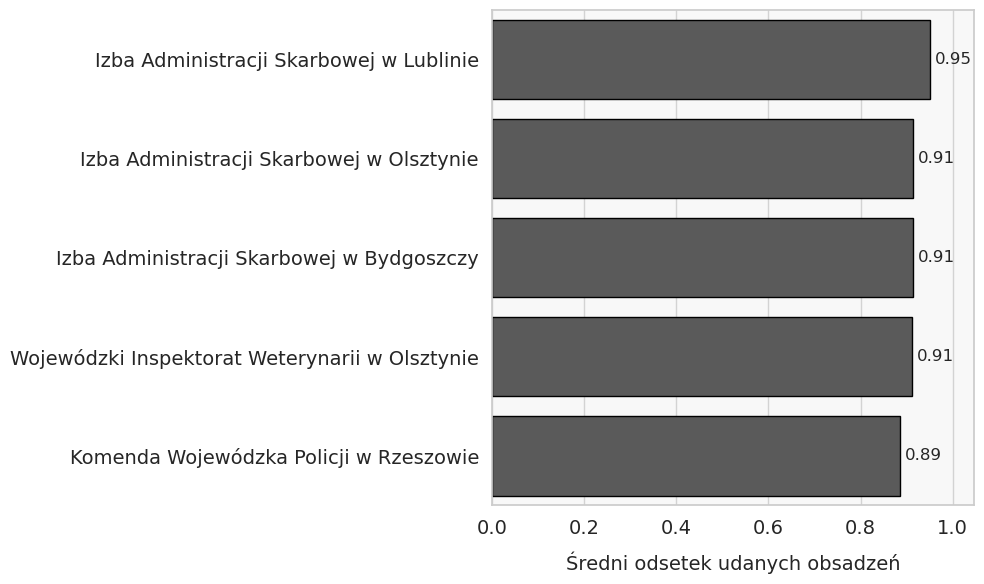

In [47]:
# Oblicz mediana i wybór instytucji z liczbą ogłoszeń > mediany
inst_counts = df['institution'].value_counts()
median_ads = inst_counts.median()
inst_high = inst_counts[inst_counts > median_ads].index

print(f"Mediana liczby ogłoszeń = {median_ads}, instytucji > mediany: {len(inst_high)}")

# Oblicz średnią i wybór instytucji z liczbą ogłoszeń > średniej
inst_counts = df['institution'].value_counts()
mean_ads = inst_counts.mean()
inst_high_mean = inst_counts[inst_counts > mean_ads].index

print(f"Średnia liczby ogłoszeń = {mean_ads}, instytucji > średniej: {len(inst_high_mean)}")

# Filtrowanie danych dla wybranych instytucji
df_high_inst = df[df['institution'].isin(inst_high_mean)]

# Oblicz średni wynik (result) dla każdej instytucji i sortuj malejąco
inst_mean_result = df_high_inst.groupby('institution')['result'].mean().reset_index()
inst_mean_result = inst_mean_result.sort_values(by='result', ascending=False)

# Wybierz top 5 instytucji
top5_inst = inst_mean_result.head(5)
print("Top 5 instytucji według średniego wyniku 'result':")
print(top5_inst)

# Wykres słupkowy (poziomy) dla top 5 instytucji
plt.figure(figsize=(10, 6))

# Set figure background to white
plt.gcf().patch.set_facecolor('white')

ax = sns.barplot(
    y='institution', x='result', data=top5_inst,
    color='#5A5A5A', edgecolor='black'
)

# Set brighter background and add grid
ax.set_facecolor('#F8F8F8')  # Light gray background for the plot area
ax.grid(True, linestyle='-', alpha=0.3, color='gray', axis='x')  # Add subtle vertical grid lines
ax.set_axisbelow(True)  # Put grid lines behind the bars

ax.set_xlabel("Średni odsetek udanych obsadzeń", labelpad=10)
ax.set_ylabel("", labelpad=10)

# etykiety bez procentów
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.2f}',
                (width + 0.01, p.get_y() + p.get_height() / 2.),
                ha='left', va='center', fontsize=12)

ax.set_xlim(0, top5_inst['result'].max() * 1.10)

plt.tight_layout()
plt.savefig("top5_result.png",
           format="png",
           bbox_inches="tight",
           facecolor='white',  # Ensures white background in saved image
           dpi=300)
plt.show()

In [48]:
# cechy do porównania
features = ['fluctuation', 'foreign_capital', 'offer_salary_mentioned', 'employment_contract', 'relative_salary']
palette_ibcs = ['#000000', '#444444', '#777777', '#AAAAAA', '#DDDDDD']

# dane: top 5 vs reszta
top5_names = top5_inst['institution'].tolist()
df_top5 = df[df['institution'].isin(top5_names)]
df_rest_top5 = df[~df['institution'].isin(top5_names)]

# mediany cech
med_top5 = df_top5[features].median()
med_rest_top5 = df_rest_top5[features].median()

# porównanie relatywne
relative_top5 = (med_top5 / med_rest_top5).reset_index()
relative_top5.columns = ['feature', 'value']

# osobna logika dla binary feature
val_top5 = df_top5['offer_salary_mentioned'].mean()
val_rest_top5 = df_rest_top5['offer_salary_mentioned'].mean()
value_ratio_top5 = (val_top5 / val_rest_top5) if val_rest_top5 > 0 else np.nan
relative_top5.loc[relative_top5['feature'] == 'offer_salary_mentioned', 'value'] = value_ratio_top5

# dane: poznań vs reszta
df_poznan = df[df['city'] == 'Poznań']
df_rest_poznan = df[df['city'] != 'Poznań']

# mediany cech
med_poznan = df_poznan[features].median()
med_rest_poznan = df_rest_poznan[features].median()

# porównanie relatywne
relative_poznan = (med_poznan / med_rest_poznan).reset_index()
relative_poznan.columns = ['feature', 'value']

# osobna logika dla binary feature
val_poznan = df_poznan['offer_salary_mentioned'].mean()
val_rest_poznan = df_rest_poznan['offer_salary_mentioned'].mean()
value_ratio_poznan = (val_poznan / val_rest_poznan) if val_rest_poznan > 0 else np.nan
relative_poznan.loc[relative_poznan['feature'] == 'offer_salary_mentioned', 'value'] = value_ratio_poznan

# wspólna skala
max_scale = max(relative_top5['value'].max(), relative_poznan['value'].max()) * 1.1

C:\Users\Konrad\AppData\Local\Temp\ipykernel_13544\4067754931.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f.replace('_', ' ') for f in relative_top5['feature']])


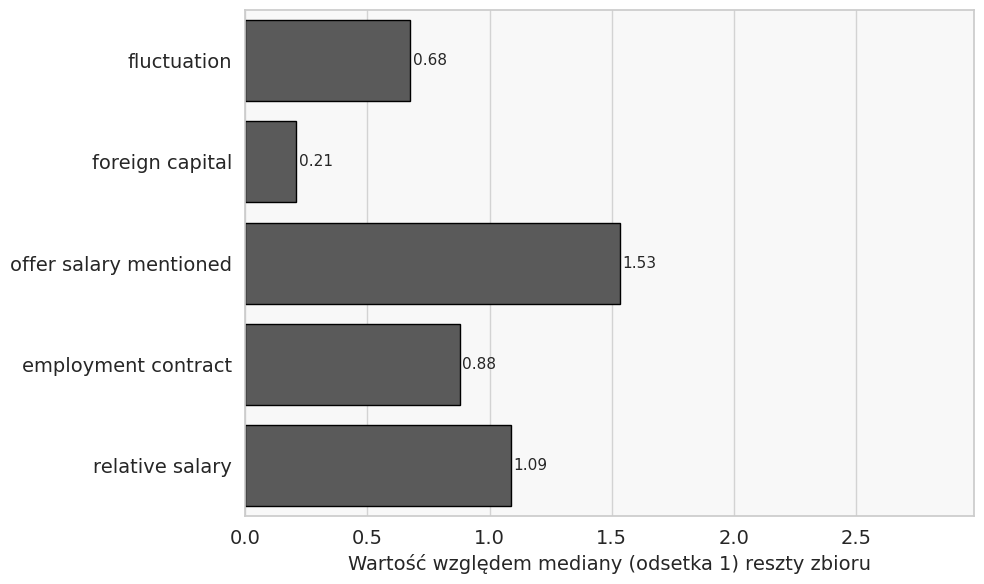

In [52]:
# wykres poziomy
plt.figure(figsize=(10, 6))

# Set figure background to white
plt.gcf().patch.set_facecolor('white')

ax = sns.barplot(
    y='feature', x='value', data=relative_top5,
    color='#5A5A5A', edgecolor='black'
)

# Set brighter background and add grid
ax.set_facecolor('#F8F8F8')  # Light gray background for the plot area
ax.grid(True, linestyle='-', alpha=0.3, color='gray', axis='x')  # Add subtle vertical grid lines
ax.set_axisbelow(True)  # Put grid lines behind the bars

# osie i tytuł
ax.set_yticklabels([f.replace('_', ' ') for f in relative_top5['feature']])
ax.set_xlabel("Wartość względem mediany (odsetka 1) reszty zbioru")
ax.set_ylabel("")

# etykiety
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.2f}',
                (width + 0.01, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=11)

# limit i styl
ax.set_xlim(0, max_scale)

plt.tight_layout()
plt.savefig("by_top5.png",
           format="png",
           bbox_inches="tight",
           facecolor='white',  # Ensures white background in saved image
           dpi=300)
plt.show()

C:\Users\Konrad\AppData\Local\Temp\ipykernel_13544\2571639822.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f.replace('_', ' ') for f in relative_poznan['feature']])


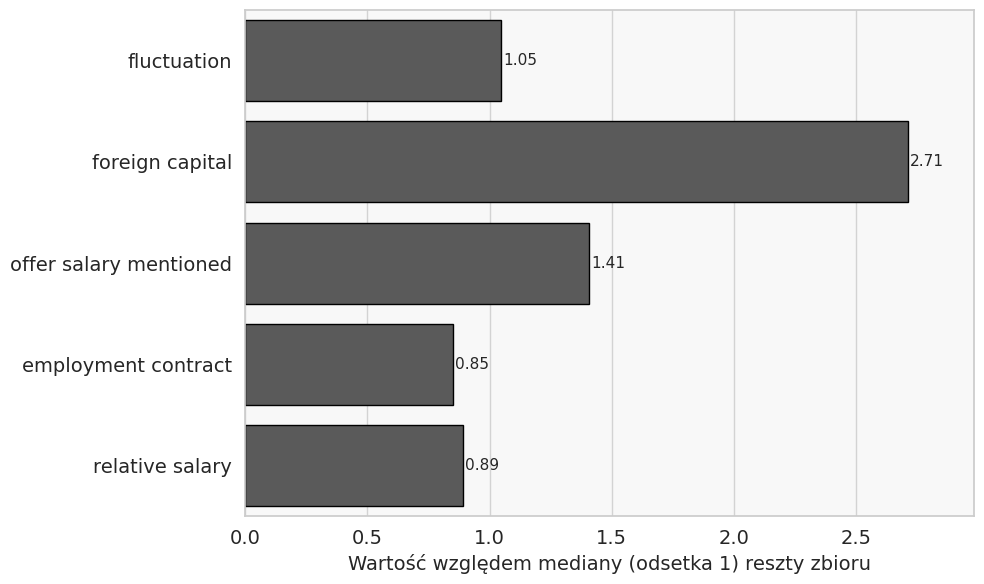

In [53]:
# wykres poziomy
plt.figure(figsize=(10, 6))

# Set figure background to white
plt.gcf().patch.set_facecolor('white')

ax = sns.barplot(
    y='feature', x='value', data=relative_poznan,
    color='#5A5A5A', edgecolor='black'
)

# Set brighter background and add grid
ax.set_facecolor('#F8F8F8')  # Light gray background for the plot area
ax.grid(True, linestyle='-', alpha=0.3, color='gray', axis='x')  # Add subtle vertical grid lines
ax.set_axisbelow(True)  # Put grid lines behind the bars

# osie i tytuł
ax.set_yticklabels([f.replace('_', ' ') for f in relative_poznan['feature']])
ax.set_xlabel("Wartość względem mediany (odsetka 1) reszty zbioru")
ax.set_ylabel("")

# etykiety
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.2f}',
                (width + 0.01, p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=11)

# limit i styl
ax.set_xlim(0, max_scale)

plt.tight_layout()
plt.savefig("by_poznan.png",
           format="png",
           bbox_inches="tight",
           facecolor='white',  # Ensures white background in saved image
           dpi=300)
plt.show()

Mediana liczby ogłoszeń (Poznań) = 18.0, instytucji > mediany: 21
Średnia liczby ogłoszeń (Poznań) = 73.46511627906976, instytucji > średniej: 9
Top 5 instytucji w Poznaniu według średniego wyniku 'result':
                                          institution    result
20             Wojskowa Komenda Uzupełnień w Poznaniu  1.000000
8        Powiatowy Inspektorat Weterynarii w Poznaniu  0.857143
18      Wojewódzki Inspektorat Weterynarii w Poznaniu  0.797468
1             Izba Administracji Skarbowej w Poznaniu  0.774228
13  Wojewódzki Inspektorat Inspekcji Handlowej w P...  0.756098


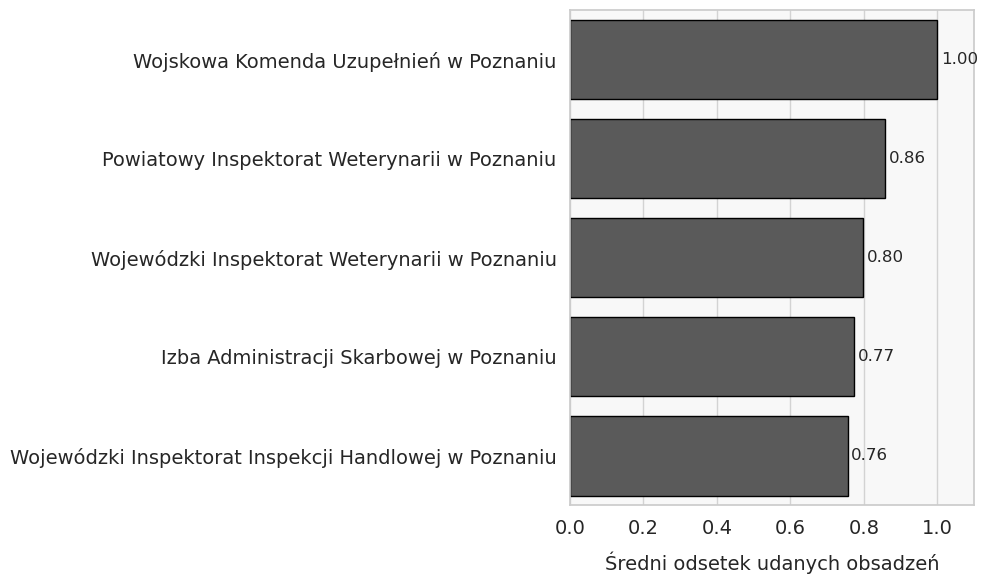

In [54]:
# Filtrowanie tylko ogłoszeń z Poznania
poznan_df = df[df['city'] == 'Poznań']

# Oblicz medianę i wybór instytucji z liczbą ogłoszeń > mediany
inst_counts = poznan_df['institution'].value_counts()
median_ads = inst_counts.median()
inst_high = inst_counts[inst_counts > median_ads].index

print(f"Mediana liczby ogłoszeń (Poznań) = {median_ads}, instytucji > mediany: {len(inst_high)}")

# Oblicz średnią i wybór instytucji z liczbą ogłoszeń > średniej
mean_ads = inst_counts.mean()
inst_high_mean = inst_counts[inst_counts > mean_ads].index

print(f"Średnia liczby ogłoszeń (Poznań) = {mean_ads}, instytucji > średniej: {len(inst_high_mean)}")

# Filtrowanie danych dla wybranych instytucji (w Poznaniu)
df_high_inst = poznan_df[poznan_df['institution'].isin(inst_high)]

# Oblicz średni wynik (result) dla każdej instytucji i sortuj malejąco
inst_mean_result = df_high_inst.groupby('institution')['result'].mean().reset_index()
inst_mean_result = inst_mean_result.sort_values(by='result', ascending=False)

# Wybierz top 5 instytucji
top5_inst = inst_mean_result.head(5)
print("Top 5 instytucji w Poznaniu według średniego wyniku 'result':")
print(top5_inst)

# Wykres słupkowy (poziomy) dla top 5 instytucji w Poznaniu
plt.figure(figsize=(10, 6))

# Set figure background to white
plt.gcf().patch.set_facecolor('white')

ax = sns.barplot(
    y='institution', x='result', data=top5_inst,
    color='#5A5A5A', edgecolor='black'
)

# Set brighter background and add grid
ax.set_facecolor('#F8F8F8')  # Light gray background for the plot area
ax.grid(True, linestyle='-', alpha=0.3, color='gray', axis='x')  # Add subtle vertical grid lines
ax.set_axisbelow(True)  # Put grid lines behind the bars

ax.set_xlabel("Średni odsetek udanych obsadzeń", labelpad=10)
ax.set_ylabel("", labelpad=10)

# etykiety
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{width:.2f}',
                (width + 0.01, p.get_y() + p.get_height() / 2.),
                ha='left', va='center', fontsize=12)

ax.set_xlim(0, top5_inst['result'].max() * 1.10)

plt.tight_layout()
plt.savefig("top5_poznan_result.png",
           format="png",
           bbox_inches="tight",
           facecolor='white',  # Ensures white background in saved image
           dpi=300)
plt.show()